# BARRA <> DEA example notebook

This is a prototype notebook demonstrating the use of BARRA reanalysis data, specifically
the BARRA-R^1 'accum_prcp'^2 variable.

To be able to execute this notebook, you will need to have completed a "licence schedule" outlining
the usage rights to BARRA data, as well as requesting access to the NCI project 'ma05'.

1 - BARRA domain representing Australian continent <br />
2 - hourly accumulated precipitation including rainfall and snowfall

For more information on BARRA and the data used in this notebook, please see:

In [1]:
import datacube
import rasterio
import time
import os
import numpy as np
from datacube.helpers import write_geotiff
from matplotlib import pyplot

## Optional helper functions

In [2]:
def write_barra_data(filename, target_dataset, source_affine, nodata=-1073741824):
    profile_override = {'nodata': nodata, 'transform': source_affine}
    write_geotiff(filename, target_dataset, profile_override=profile_override)

In [3]:
def flip_barra_data(source_dataset, target_variable='accum_prcp'):
    temp_dataarray = source_dataset[target_variable].reindex(latitude=source_dataset[target_variable].latitude[::-1])
    target_dataset = temp_dataarray.to_dataset()
    target_dataset.attrs = temp_dataarray.attrs
    return target_dataset

## Before loading BARRA data...

In [2]:
# Because GDAL struggles with the BARRA NetCDF format we have two choices:
# we leave everything unmolested but exruiciatingly slow. The big advantage is that
# we can correctly refine our spatial area of interest
# or
# we use the following directive. This helps GDAL read the file
# metadata correctly but it has the unfortunate side effect of flipping our data.
# When setting a smaller area of interest in this mode, you receive the WRONG data.
# Depending on what other data sourced you are reading from , you may need to 
# explicitly set this flag back to YES to avoid any unforeseen consequences
os.environ['GDAL_NETCDF_BOTTOMUP'] = 'NO'

# you will need a datacube confing:
config = {
    'db_hostname': 'agdcdev-db.nci.org.au',
    'db_port': 6432,
    'db_database': 'dg6911'
}
dc = datacube.Datacube(config=config)

In [5]:
#roughly Australia
query = {}
query['latitude'] = (-44,-9)
query['longitude'] = (113,154)

## Querying BARRA data

In [6]:
# this paricular BARRA variable has hourly time steps

barra_datasets = dc.find_datasets(product='accum_prcp',time='1990')
print(len(barra_datasets))

barra_datasets = dc.find_datasets(product='accum_prcp',time='1990-01')
print(len(barra_datasets))

barra_datasets = dc.find_datasets(product='accum_prcp',time='1990-01-01')
print(len(barra_datasets))

barra_datasets = dc.find_datasets(product='accum_prcp',time='1990-01-01T00:00:00.0000Z')
print(len(barra_datasets))

8760
744
24
1


In [14]:
os.environ['GDAL_NETCDF_BOTTOMUP'] = 'YES'
accum_prcp = dc.load(product='accum_prcp',
                     time='1990-01-01T00:00:00.0000Z', **query)
print(accum_prcp)

<xarray.Dataset>
Dimensions:     (latitude: 319, longitude: 373, time: 1)
Coordinates:
  * time        (time) datetime64[ns] 1990-01-01T00:29:59.999999
  * latitude    (latitude) float64 -44.05 -43.94 -43.83 ... -9.285 -9.175 -9.065
  * longitude   (longitude) float64 113.0 113.1 113.2 ... 153.7 153.8 153.9
Data variables:
    accum_prcp  (time, latitude, longitude) float64 0.02415 ... 3.121e-06
Attributes:
    crs:      GEOGCS["unknown",DATUM["unknown",SPHEROID["Sphere",6371229,0]],...


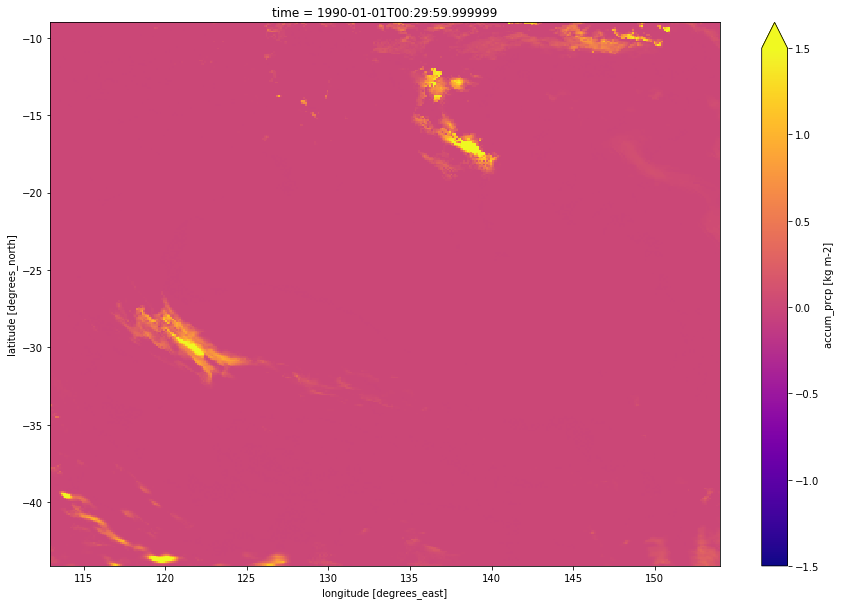

In [15]:
accum_prcp['accum_prcp'].squeeze().plot.imshow(cmap='plasma', robust=True, size=10, vmax=1.5)

## Negative values in this dataset

This particular BARRA variable is set up to use -1073741824 as the nodata and fill value. Unfortunately there appears to be many non-trivial negative values in addition to this. It's not clear if these values are valid, however they will throw off daily and monthly summaries. We will be in touch with BOM to determine what we should do with negative values, however for now we drop them.

In [18]:
filtered = accum_prcp['accum_prcp'].where(accum_prcp['accum_prcp'] >= 0, drop=True)

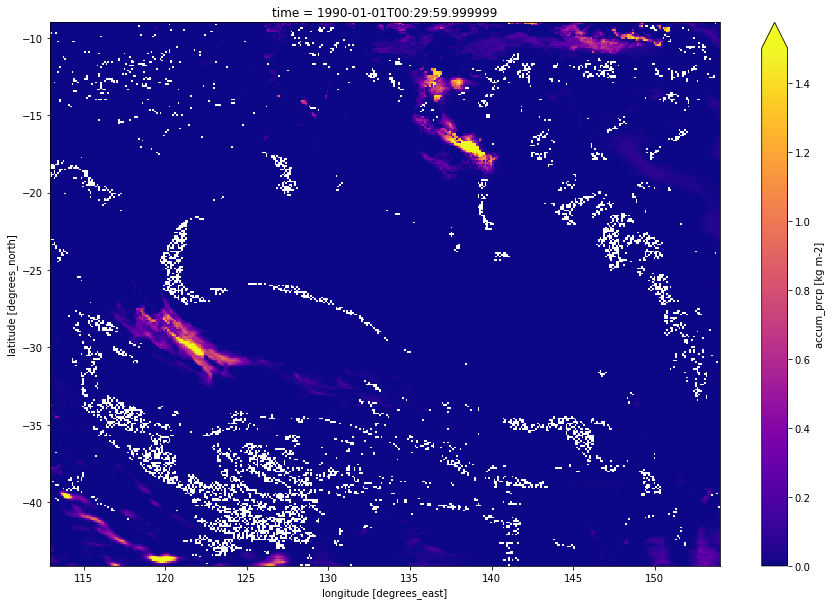

In [19]:
filtered.squeeze().plot.imshow(cmap='plasma', robust=True, size=10, vmax=1.5)

## Slow Load vs Fast Load with flip

CPU times: user 20.4 s, sys: 568 ms, total: 21 s
Wall time: 26.5 s


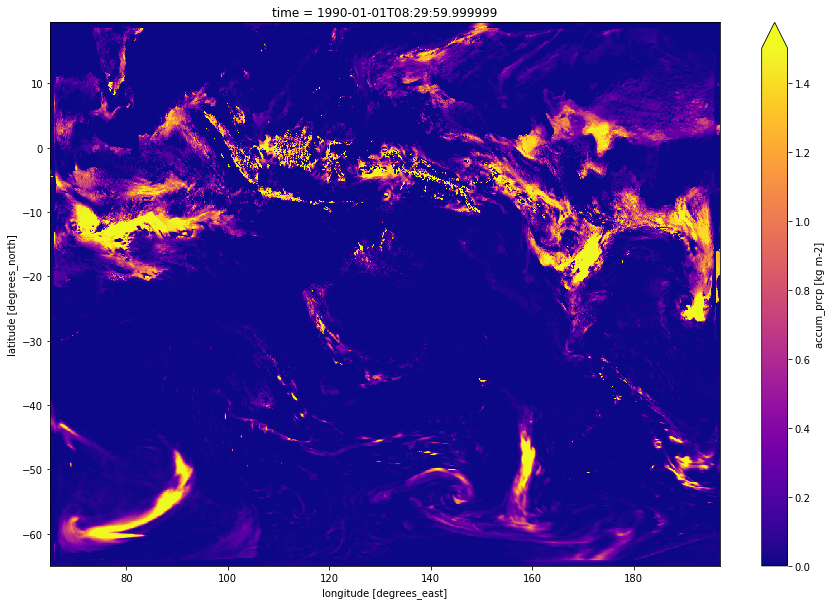

In [5]:
# Slow load
os.environ['GDAL_NETCDF_BOTTOMUP'] = 'YES' #GDAL default is YES

%time slow_accum_prcp = dc.load(product='accum_prcp', time='1990-01-01T08:00:00.0000Z')
slow_accum_prcp['accum_prcp'].squeeze().plot.imshow(cmap='plasma', size=10, robust=True, vmin=0, vmax=1.5)


CPU times: user 157 ms, sys: 107 ms, total: 264 ms
Wall time: 5.64 s


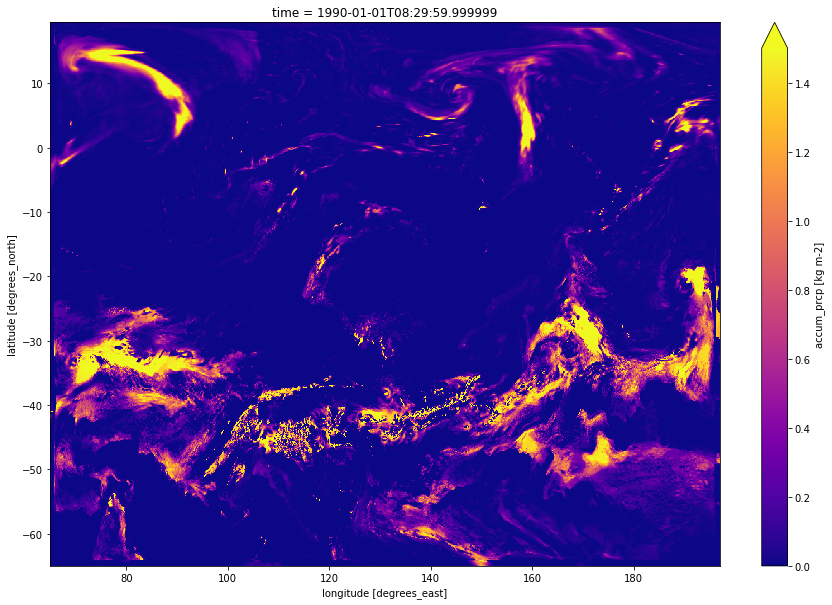

In [4]:
# Fast load, data is flipped
os.environ['GDAL_NETCDF_BOTTOMUP'] = 'NO' 

%time fast_accum_prcp = dc.load(product='accum_prcp', time='1990-01-01T08:00:00.0000Z')
fast_accum_prcp['accum_prcp'].squeeze().plot.imshow(cmap='plasma', size=10, robust=True, vmin=0, vmax=1.5)


## Flipping BARRA data back, then writing as GeoTIFF

In [23]:
# keep affine
affine = fast_accum_prcp['accum_prcp'].affine
flipped_accum_prcp = flip_barra_data(fast_accum_prcp)

# following from above
write_barra_data('19900101T0800Z_accum_prcp.tiff', flipped_accum_prcp.squeeze(), affine)

In [25]:
write_barra_data('slow_19900101T0800Z_accum_prcp.tiff', slow_accum_prcp.squeeze(), slow_accum_prcp.affine)

Hopefully you can convince yourself that these result in the same output. :)

## Producing summaries

In [26]:
os.environ['GDAL_NETCDF_BOTTOMUP'] = 'YES'
# lets produce a daily summary of total precipitation
%time  accum_prcp = dc.load(product='accum_prcp', time='1990-01-01', **query)

CPU times: user 3min 12s, sys: 8 s, total: 3min 20s
Wall time: 3min 32s


In [28]:
# filter out negative values
filtered_sum = accum_prcp['accum_prcp'].where(accum_prcp['accum_prcp'] >= 0, drop=True).sum(dim='time')

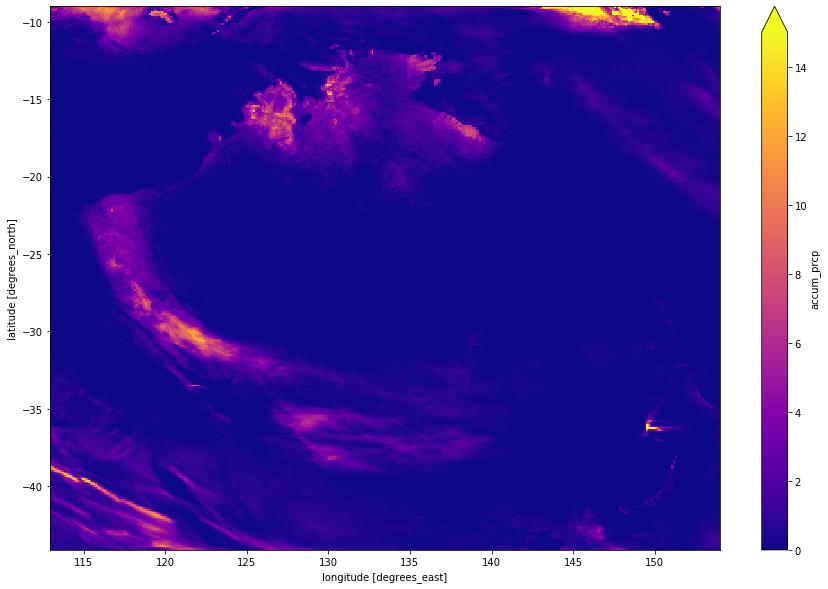

In [32]:
filtered_sum.plot.imshow(cmap='plasma', size=10, robust=True, vmax=15)

In [36]:
# keep affine
affine = accum_prcp['accum_prcp'].affine
# turn back into dataset
total_day_accumprcp_dataset = filtered_sum.to_dataset()
total_day_accumprcp_dataset['accum_prcp'].attrs = accum_prcp['accum_prcp'].attrs
total_day_accumprcp_dataset.attrs = accum_prcp['accum_prcp'].attrs

#write to disk
write_barra_data('19900101_total_accum_prcp.tiff', total_day_accumprcp_dataset, affine)

## Load BARRA faster using DASK

In [ ]:
import dask
import dask.distributed

client = dask.distributed.Client(n_workers=8,
                                 threads_per_worker=1,
                                 memory_limit='3G',
                                 ip='127.0.0.1')
client

In [ ]:
accum = dc.load(product='accum_prcp',
             dask_chunks={'time':6},
               time='1990-01',
               skip_broken_datasets=True, **query)

display(accum)

In [ ]:
%time loaded_accum = accum['accum_prcp'].compute()

In [ ]:
%time filtered_sum = loaded_accum.where(loaded_accum >= 0, drop=True).sum(dim='time')

In [ ]:
filtered_sum.squeeze().plot.imshow(cmap='plasma', size=10, robust=True, vmin=0, vmax=1000)

In [ ]:
## turn back into dataset
total_day_accumprcp_dataset = filtered_sum.to_dataset()
total_day_accumprcp_dataset.attrs = accum['accum_prcp'].attrs

##write to disk
write_barra_data('199001total_accum_prcp.tiff', total_day_accumprcp_dataset, accum.affine)